In [1]:
import tensorflow as tf
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array
import time
import imageio

class PixelNormalization(tf.keras.layers.Layer):
    def call(self, inputs):
        return inputs / tf.sqrt(tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True) + 1e-8)


tf.config.run_functions_eagerly(True)

def alpha_numeric_sort(lst):
    convert_fn = lambda text: int(text) if text.isdigit() else text.lower()
    sort_key = lambda key: [convert_fn(c) for c in re.split('([0-9]+)', key)]
    return sorted(lst, key=sort_key)

IMG_SIZE = (1024, 1024)  # Higher resolution
image_data = []
data_dir = 'C:\\Users\\Asus\\Desktop\\Image_generating_using_IGAN\\normal_faces'
image_files = os.listdir(data_dir)
image_files = alpha_numeric_sort(image_files)

100%|████████████████████████████████████████████████████████████████████████████████| 307/307 [00:11<00:00, 26.72it/s]


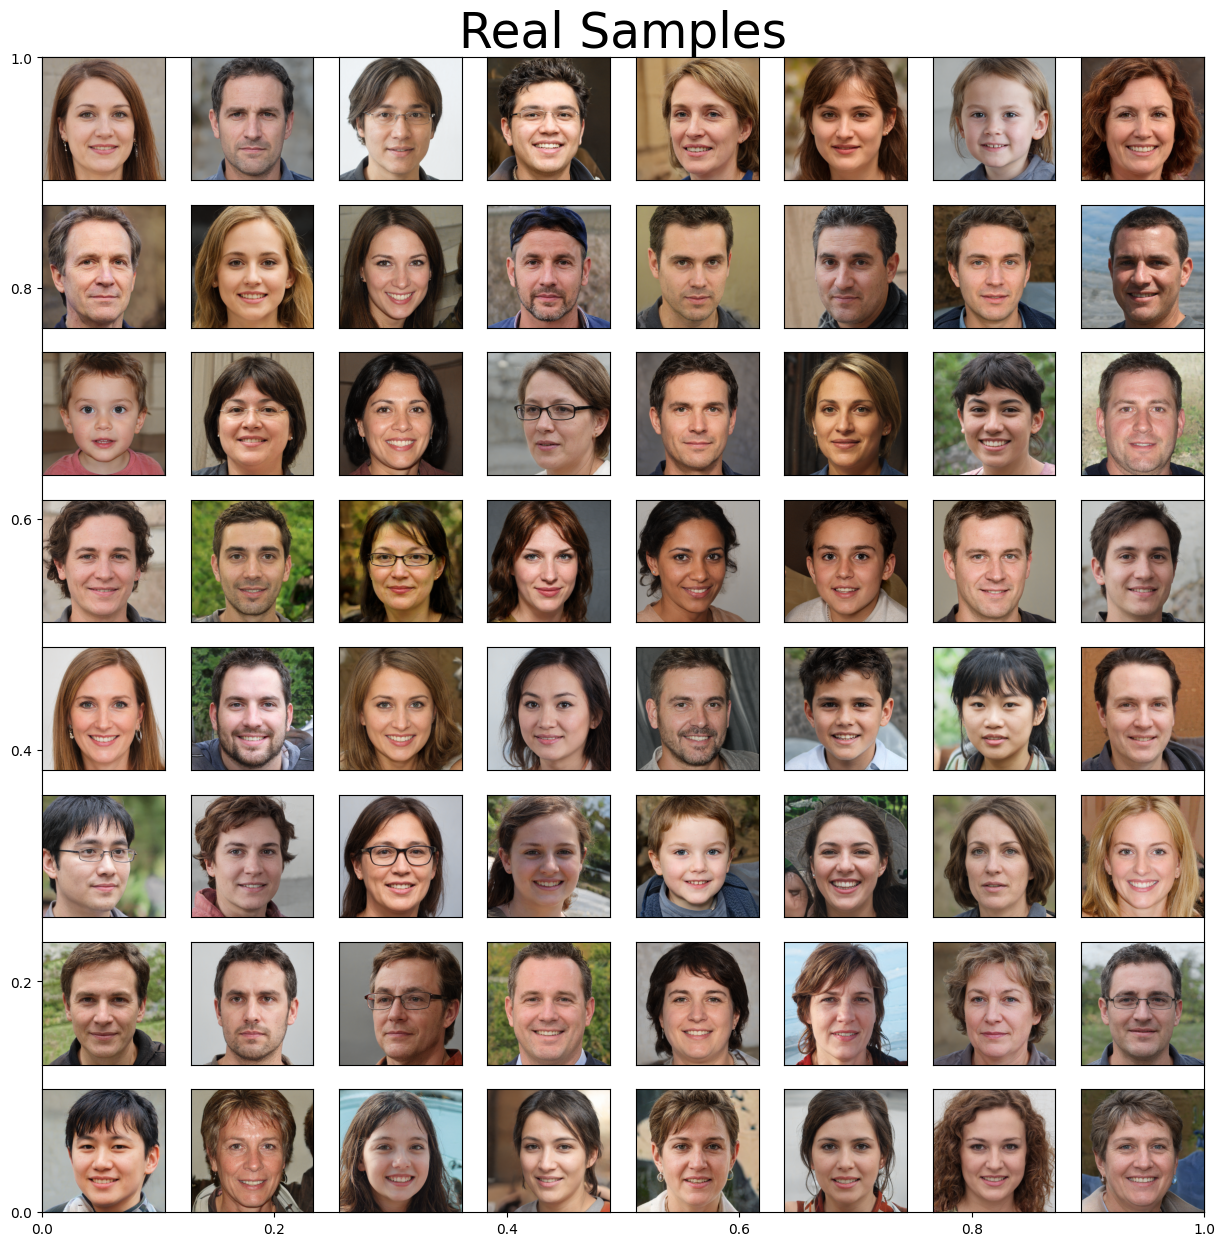

In [2]:
for filename in tqdm(image_files):
    image = cv2.imread(os.path.join(data_dir, filename), 1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, IMG_SIZE)
    image = (image - 127.5) / 127.5
    image_data.append(img_to_array(image))

def show_images(grid=8):
    plt.figure(figsize=(15, 15))
    plt.title("Real Samples", fontsize=35)
    for idx in range(min(grid * grid, len(image_data))):
        plt.subplot(grid, grid, idx + 1)
        plt.imshow(image_data[idx] * 0.5 + 0.5)
        plt.xticks([]); plt.yticks([])

show_images(8)

batch_sz = 8
data_pipeline = tf.data.Dataset.from_tensor_slices(np.array(image_data)).batch(batch_sz)



In [3]:
z_dim = 100

# Generator
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(z_dim,)))
    model.add(layers.Reshape((8, 8, 512)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, 4, strides=2, padding='same', use_bias=False))  # 16x16
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False))  # 32x32
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False))   # 64x64
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, 4, strides=2, padding='same', use_bias=False))   # 128x128
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, 3, strides=1, padding='same', activation='tanh'))  # Final RGB output

    return model


gen_model = build_generator()
gen_model.summary()



C:\Users\Asus\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32768)               │       3,276,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 256)         │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 128, 128, 32)        │          32,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128, 128, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 128, 128, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,066,915 (23.14 MB)

 Trainable params: 6,064,931 (23.14 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [4]:
# Discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(128, 128, 3)))

    model.add(layers.Conv2D(64, 4, strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(512, 4, strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


disc_model = build_discriminator()
disc_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 64)          │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 512)           │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 8, 8, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,792,897 (10.65 MB)

 Trainable params: 2,791,105 (10.65 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [5]:
# Optimizers (must be separate!)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Loss
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def loss_for_generator(pred_fake):
    return bce_loss(tf.ones_like(pred_fake), pred_fake)

def loss_for_discriminator(pred_fake, pred_real):
    # Label smoothing & noise
    real_labels = tf.ones_like(pred_real) * tf.random.uniform(shape=tf.shape(pred_real), minval=0.9, maxval=1.0)
    fake_labels = tf.zeros_like(pred_fake) + tf.random.uniform(shape=tf.shape(pred_fake), minval=0.0, maxval=0.1)

    loss_fake = bce_loss(fake_labels, pred_fake)
    loss_real = bce_loss(real_labels, pred_real)
    return loss_fake + loss_real




In [6]:
@tf.function
def perform_train_step(batch_images):
    noise = tf.random.normal([batch_sz, z_dim])
    with tf.GradientTape() as tape_gen, tf.GradientTape() as tape_disc:
        generated_images = gen_model(noise, training=True)
        pred_fake = disc_model(generated_images, training=True)
        pred_real = disc_model(batch_images, training=True)

        g_loss = loss_for_generator(pred_fake)
        d_loss = loss_for_discriminator(pred_fake, pred_real)

    grads_gen = tape_gen.gradient(g_loss, gen_model.trainable_variables)
    grads_disc = tape_disc.gradient(d_loss, disc_model.trainable_variables)

    gen_optimizer.apply_gradients(zip(grads_gen, gen_model.trainable_variables))
    disc_optimizer.apply_gradients(zip(grads_disc, disc_model.trainable_variables))

    return {"g_loss": g_loss, "d_loss": d_loss}



In [7]:
# Show generated samples
def show_generated_images(grid=8, current_epoch=0):
    plt.figure(figsize=(10, 10))
    for idx in range(grid * grid):
        plt.subplot(grid, grid, idx + 1)
        noise = tf.random.normal([1, z_dim])
        img = gen_model(noise, training=False)
        img = (img[0] + 1) / 2.0
        plt.imshow(img.numpy())
        plt.xticks([]); plt.yticks([])
    if current_epoch:
        plt.suptitle(f"Generated Samples - Epoch {current_epoch}", fontsize=20)
    plt.tight_layout()
    plt.show()

# Save generated images to disk (used for GIF creation)
def save_generated_images_for_gif(grid=8, current_epoch=0, output_dir="generated_images"):
    os.makedirs(output_dir, exist_ok=True)
    fig = plt.figure(figsize=(10, 10))
    for idx in range(grid * grid):
        plt.subplot(grid, grid, idx + 1)
        noise = tf.random.normal([1, z_dim])
        img = gen_model(noise, training=False)
        img = (img[0] + 1) / 2.0
        plt.imshow(img.numpy())
        plt.xticks([]); plt.yticks([])

    plt.suptitle(f"Epoch {current_epoch}", fontsize=20)
    plt.tight_layout()

    filepath = os.path.join(output_dir, f"epoch_{current_epoch:03d}.png")
    plt.savefig(filepath)
    plt.close(fig)



Epoch 1
Duration: 33.61s
Generator Loss: 4.5187, Discriminator Loss: 0.9236

Epoch 2
Duration: 33.65s
Generator Loss: 3.9745, Discriminator Loss: 0.3087

Epoch 3
Duration: 34.72s
Generator Loss: 5.5198, Discriminator Loss: 0.5997

Epoch 4
Duration: 33.64s
Generator Loss: 2.5497, Discriminator Loss: 0.9059

Epoch 5
Duration: 33.98s
Generator Loss: 2.1898, Discriminator Loss: 1.3109

Epoch 6
Duration: 33.66s
Generator Loss: 3.3704, Discriminator Loss: 0.5603

Epoch 7
Duration: 33.26s
Generator Loss: 5.9326, Discriminator Loss: 1.1492

Epoch 8
Duration: 33.11s
Generator Loss: 5.5759, Discriminator Loss: 1.0659

Epoch 9
Duration: 32.93s
Generator Loss: 3.9658, Discriminator Loss: 0.5664

Epoch 10
Duration: 33.08s
Generator Loss: 2.4401, Discriminator Loss: 0.8369

Epoch 11
Duration: 33.11s
Generator Loss: 5.6011, Discriminator Loss: 0.6546

Epoch 12
Duration: 33.18s
Generator Loss: 5.3541, Discriminator Loss: 0.5264

Epoch 13
Duration: 33.06s
Generator Loss: 3.6331, Discriminator Loss: 0.

C:\Users\Asus\AppData\Local\Temp\ipykernel_17332\2830149103.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(os.path.join(image_dir, f)) for f in files]



✅ Saved training progress GIF: training_progress.gif


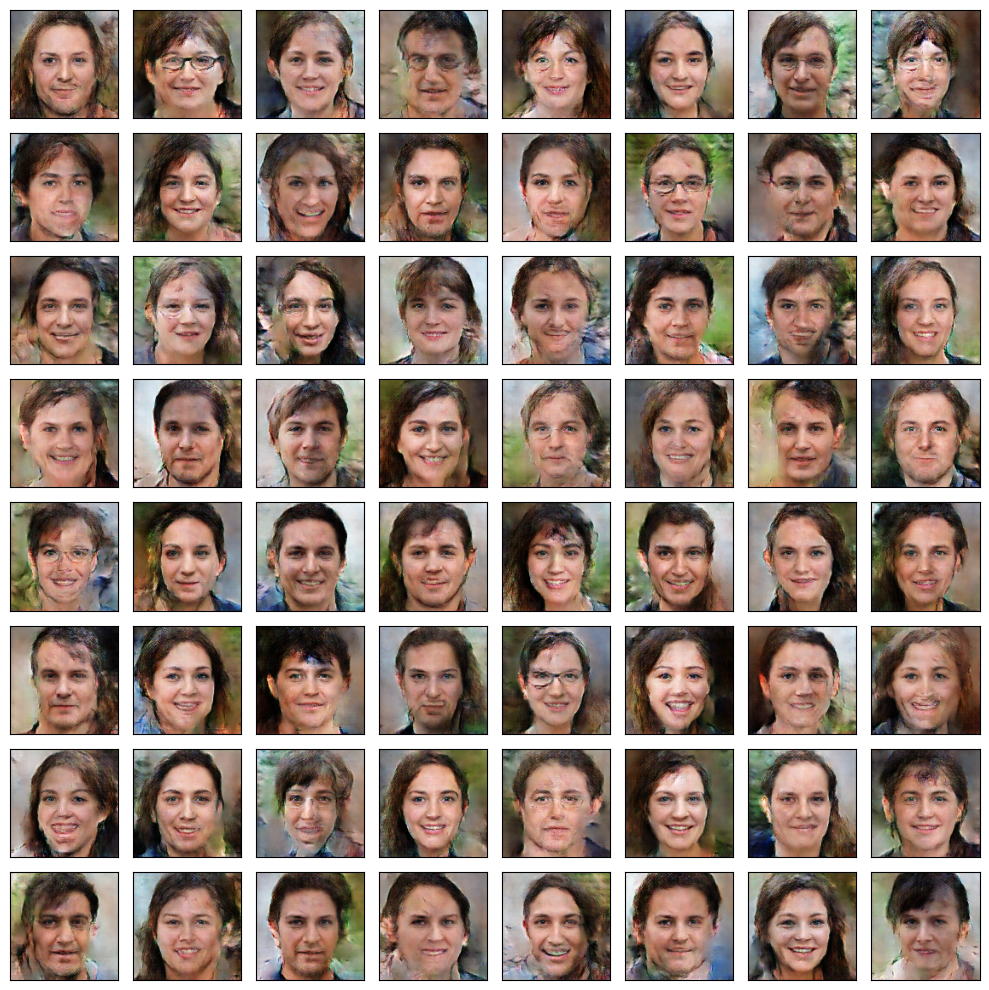

In [8]:
# Create GIF from saved images
def create_training_gif(image_dir="generated_images", gif_name="training_progress.gif", fps=2):
    files = alpha_numeric_sort([f for f in os.listdir(image_dir) if f.endswith(".png")])
    images = [imageio.imread(os.path.join(image_dir, f)) for f in files]
    imageio.mimsave(gif_name, images, fps=fps)
    print(f"\n✅ Saved training progress GIF: {gif_name}")


# Training loop
def start_training(total_epochs, input_dataset):
    for ep in range(total_epochs):
        start_time = time.time()
        print(f"\nEpoch {ep + 1}")
        for batch in input_dataset:
            resized_batch = tf.image.resize(batch, [128, 128])
            losses = perform_train_step(resized_batch)
        print(f"Duration: {time.time() - start_time:.2f}s")
        print(f"Generator Loss: {losses['g_loss']:.4f}, Discriminator Loss: {losses['d_loss']:.4f}")
        if (ep + 1) % 20 == 0:
            save_generated_images_for_gif(8, ep + 1)

    create_training_gif()


# Start training
start_training(200, data_pipeline)

# Final results
show_generated_images(8)

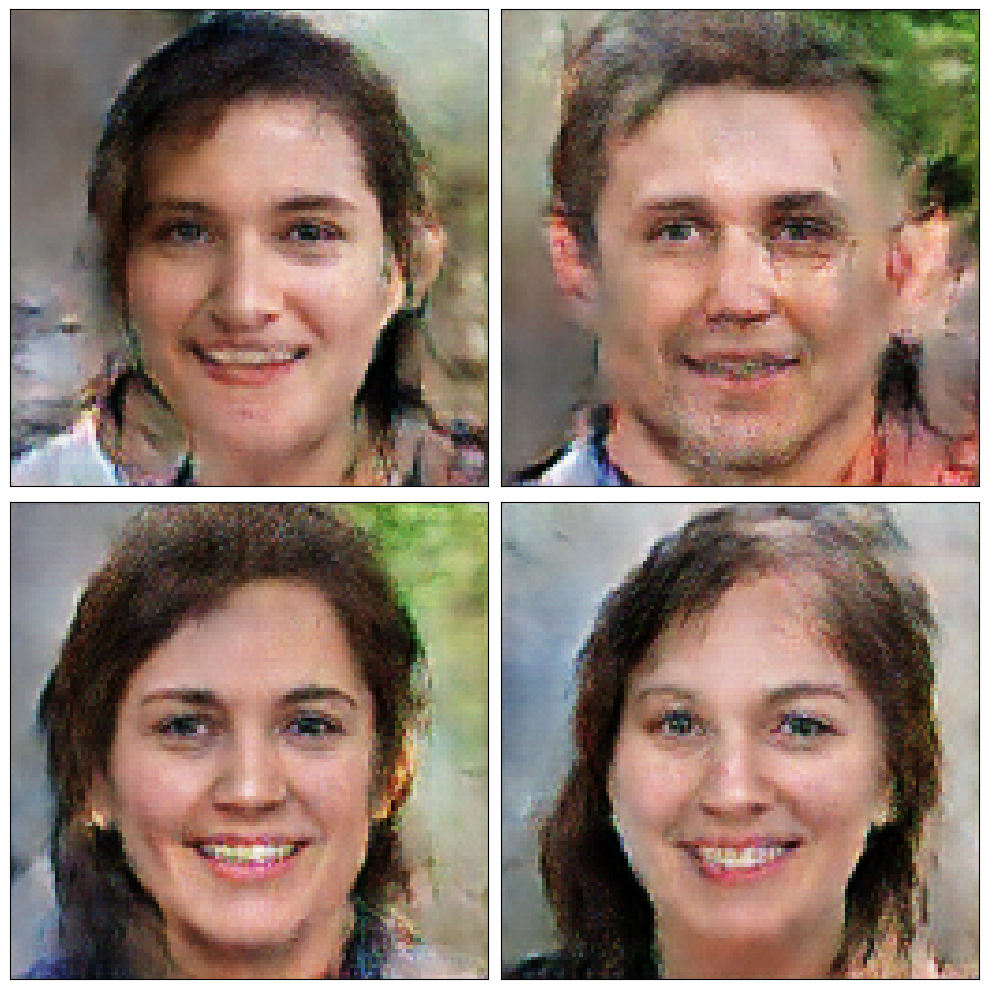

In [9]:
show_generated_images(2)

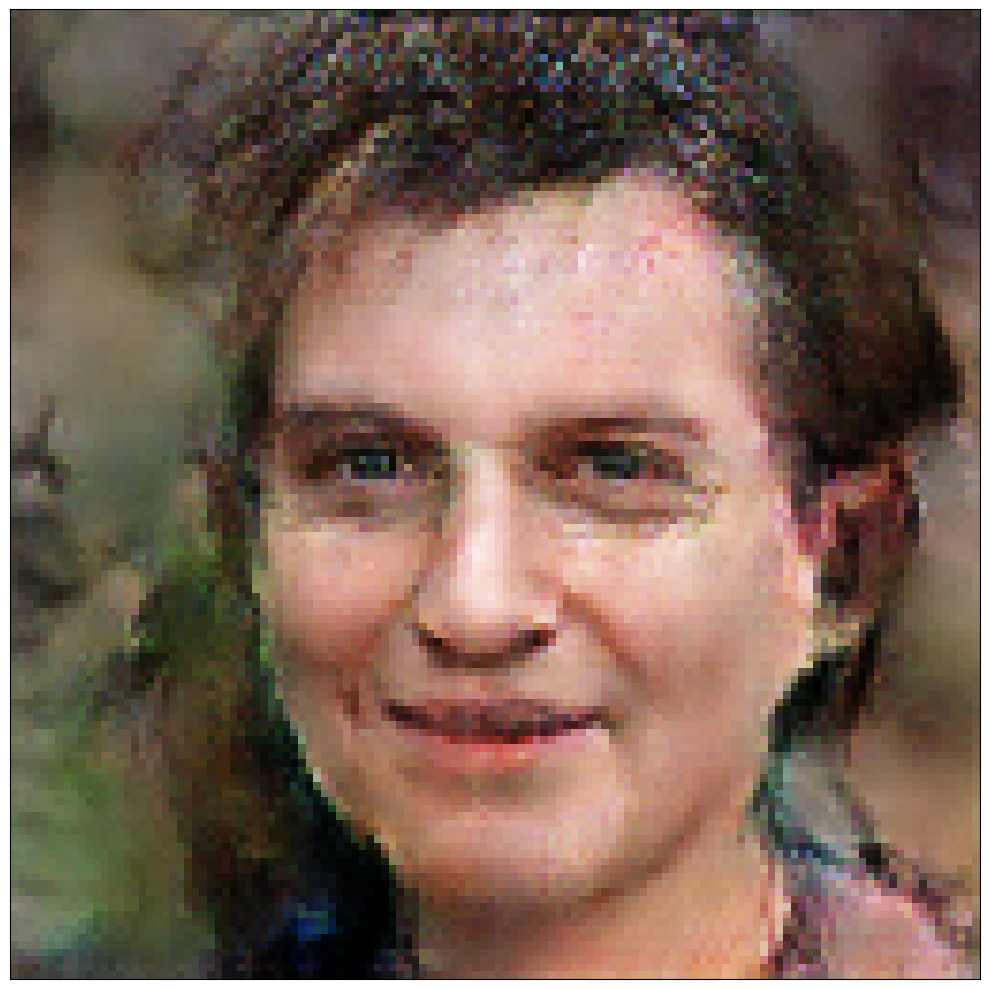

In [10]:
show_generated_images(1)